<a href="https://colab.research.google.com/github/KDZ7/ImageClassification-TensorFlow-DeepLearning/blob/main/GTSRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comminication entre l'API Kaggle et Google Colab**

In [ ]:
output_dir      = '/content/drive/MyDrive/kaggle/work'
output_dir_tmp  = '/content/tmp/work'
dataset_dir_tmp = '/content/tmp/dataset'

In [ ]:
ratio = 0.1 # %Images Training
pixels = 48

# **Repertoire permanent et temporaire**

In [ ]:
!pip install kaggle -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle/ && cp '{output_dir}/../kaggle.json' ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data                            Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          14763        266  1.0              
sudarshan24byte/online-food-dataset                           Online Food Dataset                                  3KB  2024-03-02 18:50:30           4606         76  0.9411765        
arnavvvvv/spotify-music                                       Top Spotify Songs                                   47KB  2024-03-06 05:20:29           4169         59  1.0              
tarunrm09/climate-change-indicators                           Climate chang

In [ ]:
!mkdir -p '{dataset_dir_tmp}' && kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p '{dataset_dir_tmp}' && unzip -n {dataset_dir_tmp}/gtsrb-german-traffic-sign.zip -d '{dataset_dir_tmp}'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/tmp/dataset/train/5/00005_00053_00010.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00011.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00012.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00013.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00014.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00015.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00016.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00017.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00018.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00019.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00020.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00021.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00022.png  
  inflating: /content/tmp/dataset/train/5/00005_00053_00023.png 

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from datetime import datetime

import cv2
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform
from tqdm import tqdm

import os

*Summary of dataset preparation. For more details visit* [here](https://gricad-gitlab.univ-grenoble-alpes.fr/talks/fidle/-/blob/master/GTSRB.Keras3/01-Preparation-of-data.ipynb?ref_type=heads)

**Enhanced datasets**

# **1. Preparation of datasets**

In [ ]:
df = pd.read_csv(f'{dataset_dir_tmp}/Test.csv', header=0)
display(df.head(10))

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


# ***Usefull functions***
**A nice function for reading a dataset from an index.csv file.\
Input: an intex.csv file\
Output: an array of images ans an array of corresponding labels**

In [ ]:
def read_csv_dataset(csv_file):
    '''
    Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.
    Arguments:
        csv filename :  Description file, Example /data/GTSRB/Train.csv
    Returns:
        x,y          :  np array of images, np array of corresponding labels
    '''

    path = os.path.dirname(csv_file)
    name = os.path.basename(csv_file)

    # ---- Read csv file
    #
    df = pd.read_csv(csv_file, header=0)

    # ---- Get filenames and ClassIds
    #
    filenames = df['Path'].to_list()
    y         = df['ClassId'].to_list()
    x         = []

    # ---- Read images
    #
    for filename in tqdm(filenames, desc='Loading Images', unit=' image'):
        image=io.imread(f'{path}/{filename}')
        x.append(image)

    # ---- Return
    #
    return (np.array(x,dtype=object), np.array(y))

In [ ]:
(x_train, y_train) = read_csv_dataset(f'{dataset_dir_tmp}/Train.csv')
(x_test,  y_test)  = read_csv_dataset(f'{dataset_dir_tmp}/Test.csv')
(x_meta,  y_meta)  = read_csv_dataset(f'{dataset_dir_tmp}/Meta.csv')

# ---- Shuffle train set
x_train, y_train = shuffle(x_train, y_train)

# ---- Sort Meta
combined = list(zip(x_meta, y_meta))
combined.sort(key=lambda x: x[1])
x_meta, y_meta = zip(*combined) # dézipper

Loading Images: 100%|██████████| 43/43 [00:00<00:00, 1297.01 image/s]


In [ ]:
# ------ Global stuff
print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("x_test  shape : ",x_test.shape)
print("y_test  shape : ",y_test.shape)
print("x_meta  size  : ",len(x_meta))
print("y_meta  size  : ",len(y_meta))

x_train shape :  (39209,)
y_train shape :  (39209,)
x_test  shape :  (12630,)
y_test  shape :  (12630,)
x_meta  size  :  43
y_meta  size  :  43


# **Show Dataset**

In [ ]:
def show(
    images,
    targets,
    figsize=(16, 8),
    index_range=(1, 17),
    subplot=(4, 4),
    axis_onoff="off",
    cmap=None,
):
    plt.figure(figsize=figsize)
    for i in range(*index_range):
        plt.subplot(*subplot, i)
        plt.imshow(images[i], cmap=cmap)
        plt.title(targets[i])
        plt.axis(axis_onoff)
    plt.tight_layout()
    plt.show()
    print("><")
    return

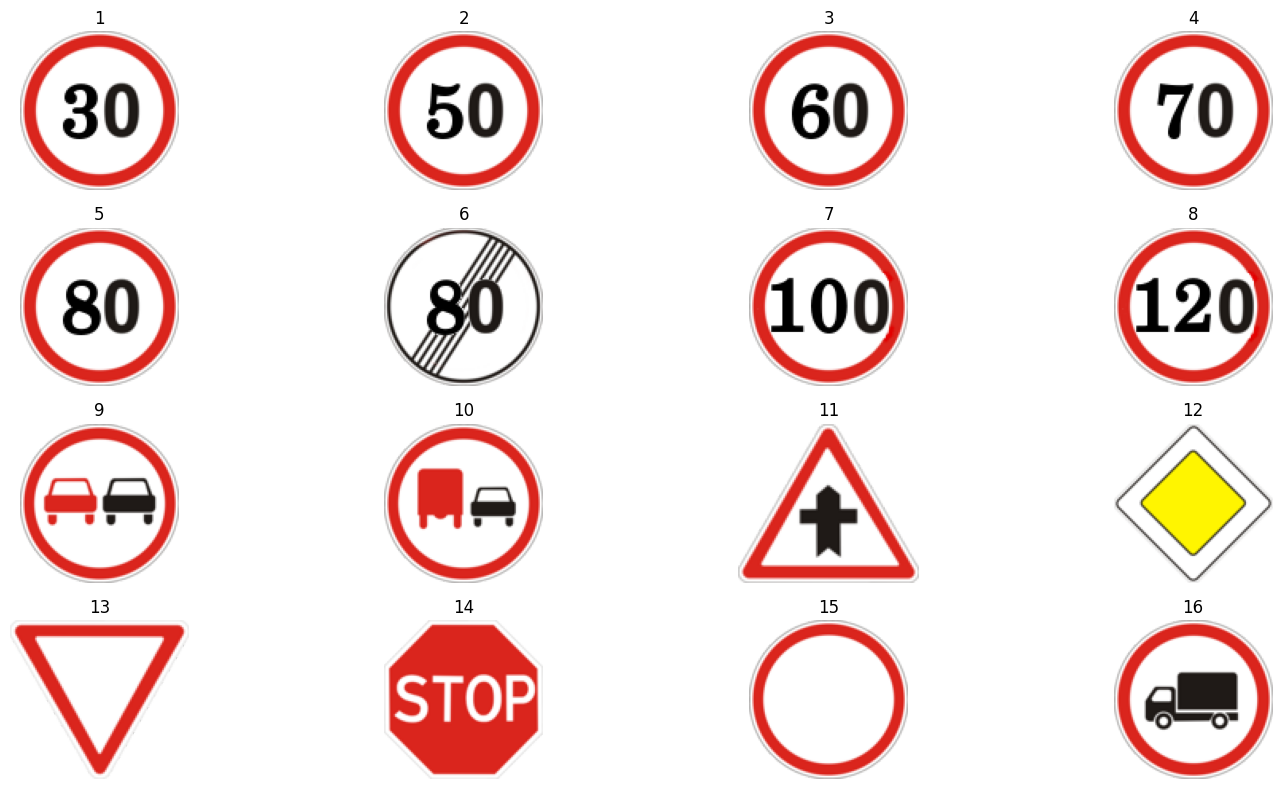

><


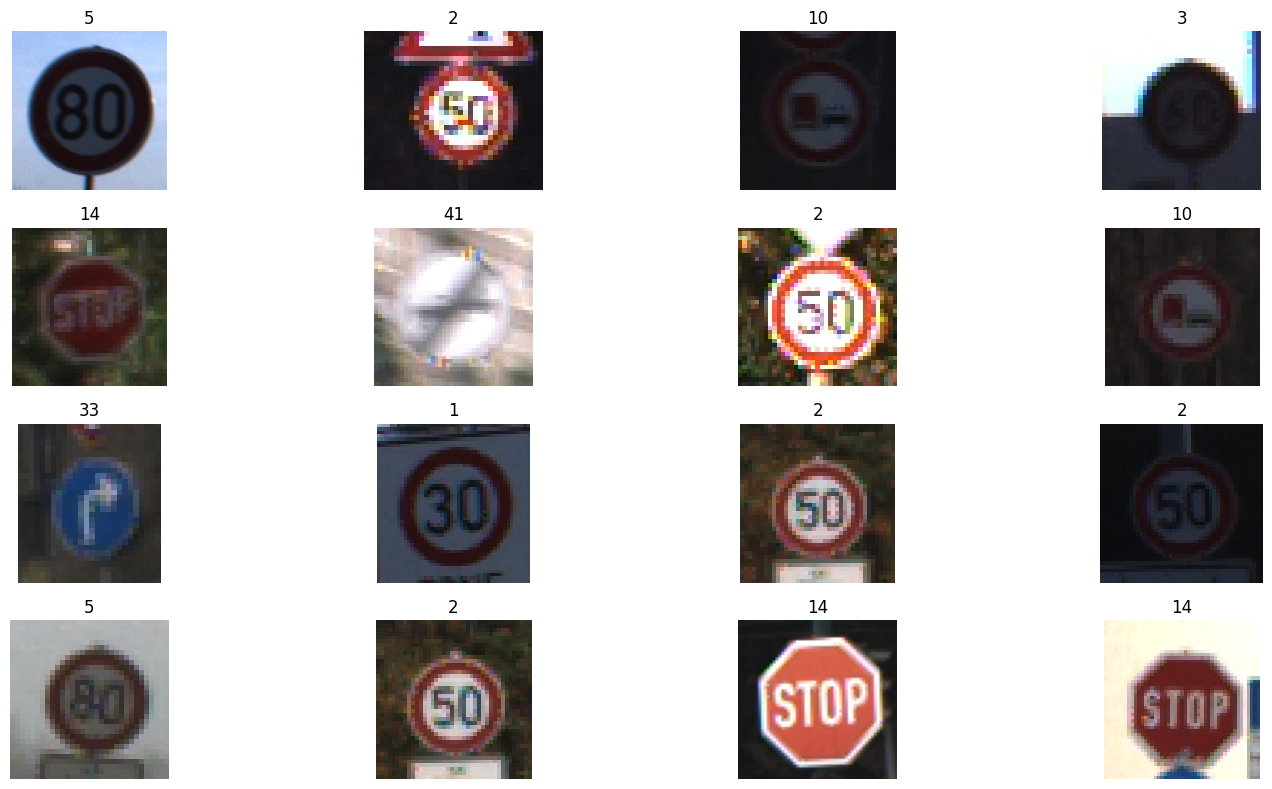

><


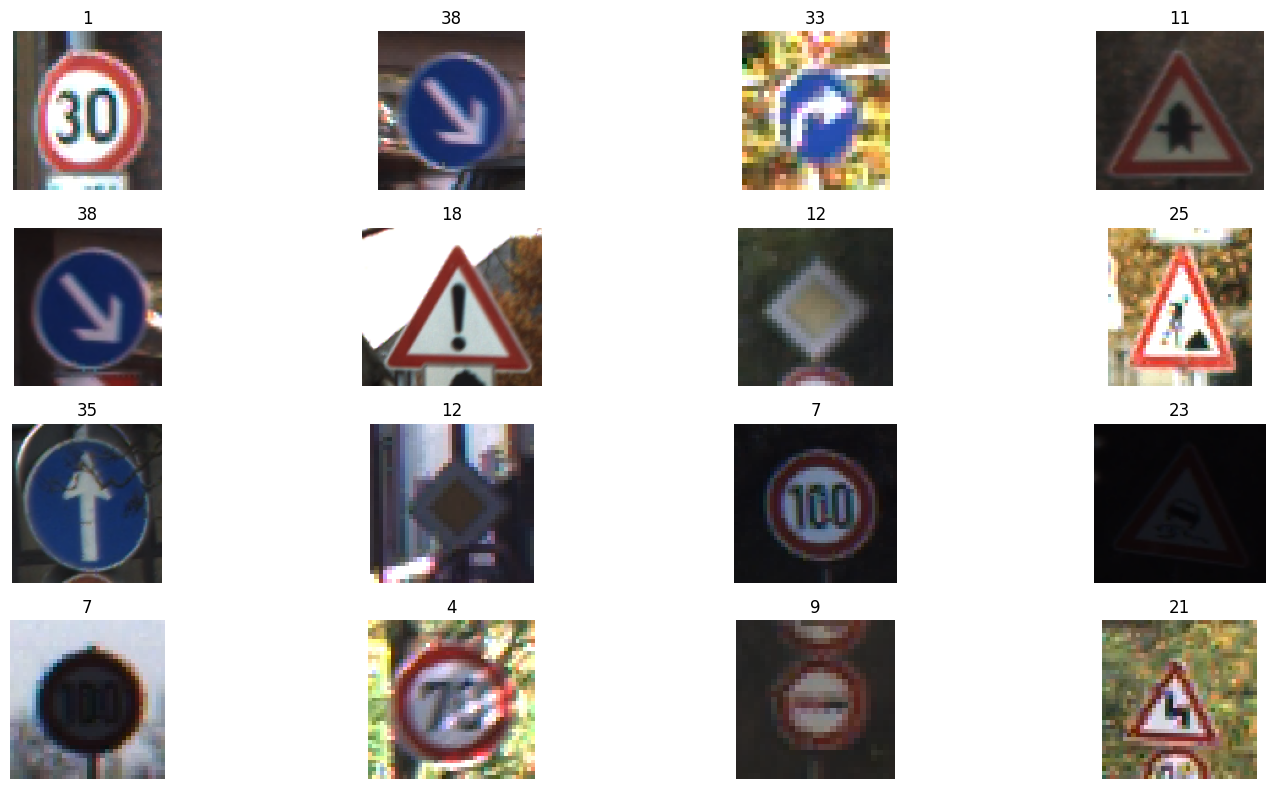

><


In [ ]:
show(x_meta, y_meta)
show(x_train, y_train)
show(x_test, y_test)

# **Enhancement cooking**
**A nice function for preparing our data.Input: a set of images (numpy array)Output: a enhanced images, resized and reprocessed (numpy array)**

In [ ]:
def images_enhancement(images, width=24, height=24, proc='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    Note : all outputs are fixed size numpy array of float32
    args:
        images :         images list
        width,height :   new images size (24, 24)
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE
    return:
        numpy array of enhanced images
    '''
    lz={ 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}[proc]

    out=[]

    for img in tqdm(images, desc="Enhancing images", unit=' image'):

        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)

        # ---- Resize
        img = transform.resize(img, (width, height))

        # ---- RGB / Histogram Equalization
        if proc=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width, height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)

        # ---- Grayscale
        if proc=='L':
            img=color.rgb2gray(img)

        # ---- Grayscale / Histogram Equalization
        if proc=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)

        # ---- Grayscale / Local Histogram Equalization
        if proc=='L-LHE':
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.

        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if proc=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)

        # ---- Add image in list of list
        out.append(img)

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out, dtype='float32')
    out = out.reshape(-1, width, height, lz)
    return out

# **To get an idea of the different recipes**

Enhancing images: 100%|██████████| 32/32 [00:00<00:00, 188.18 image/s]


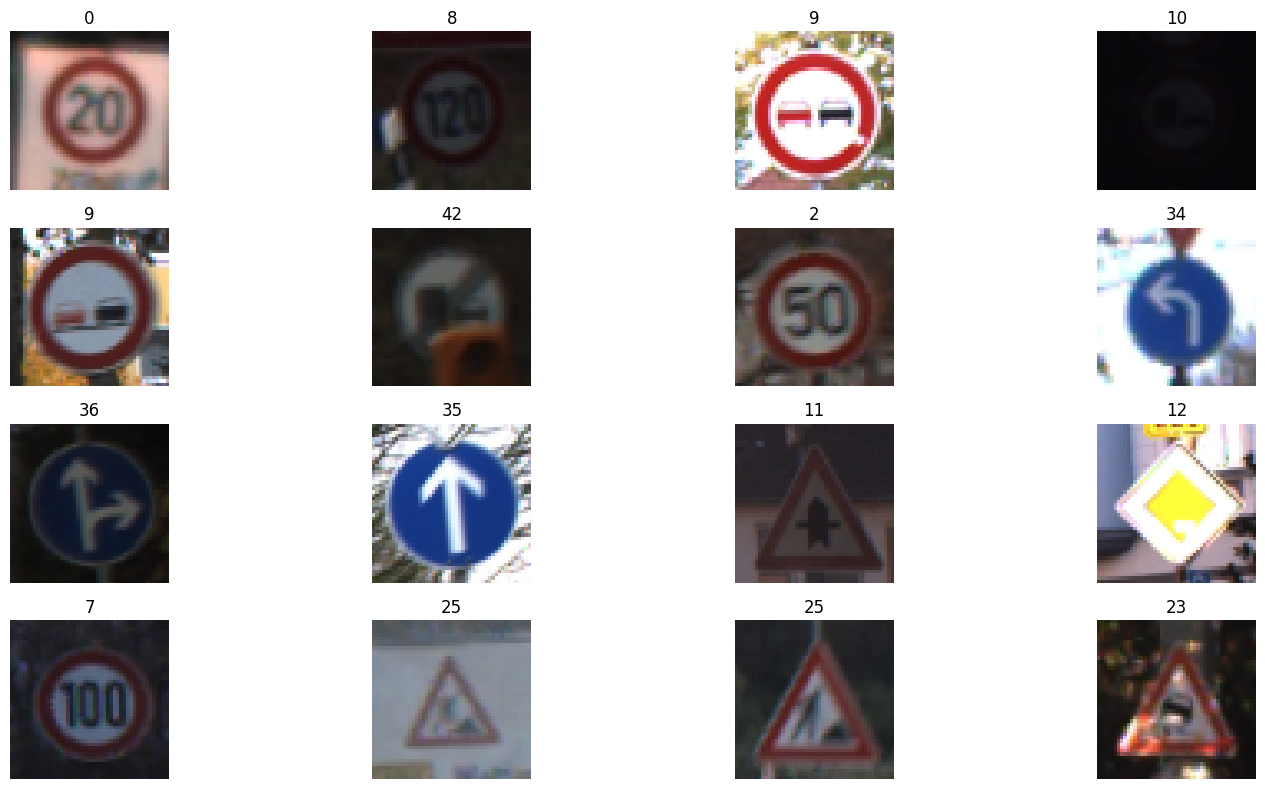

><


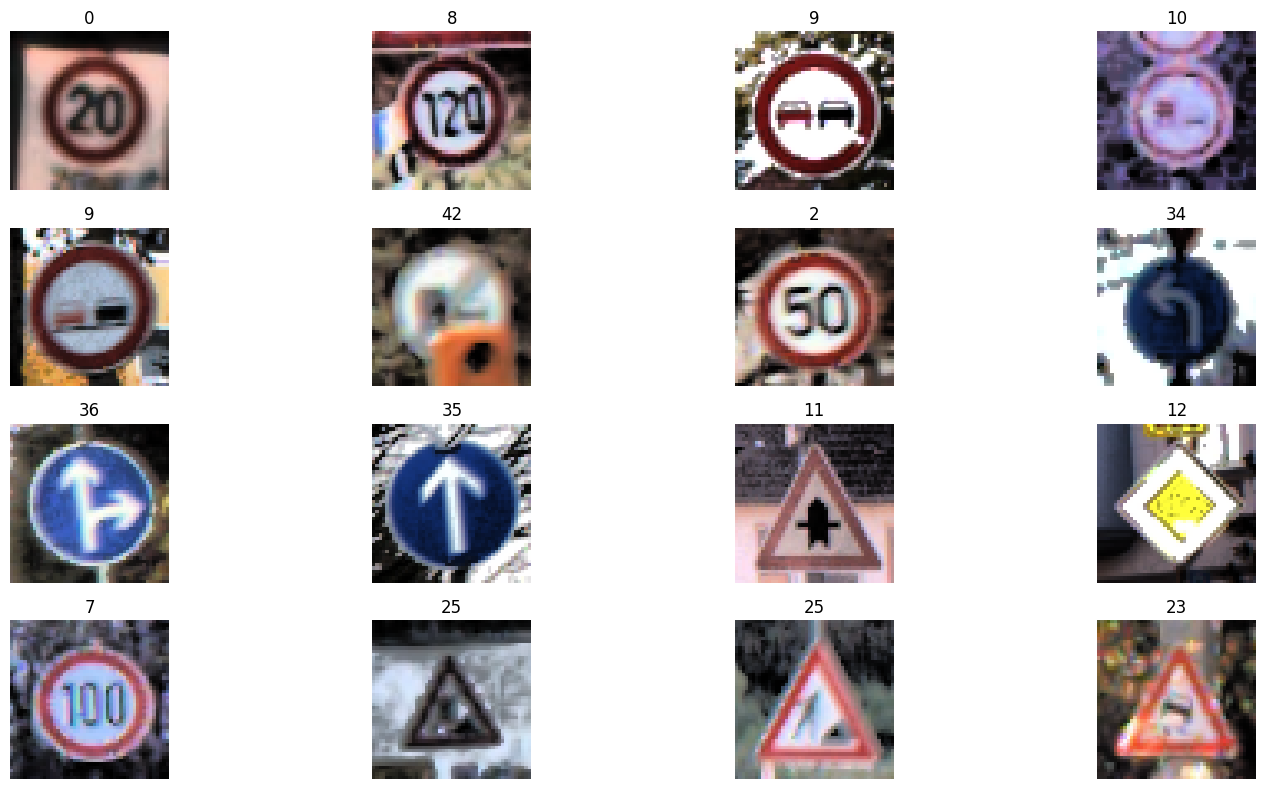

><


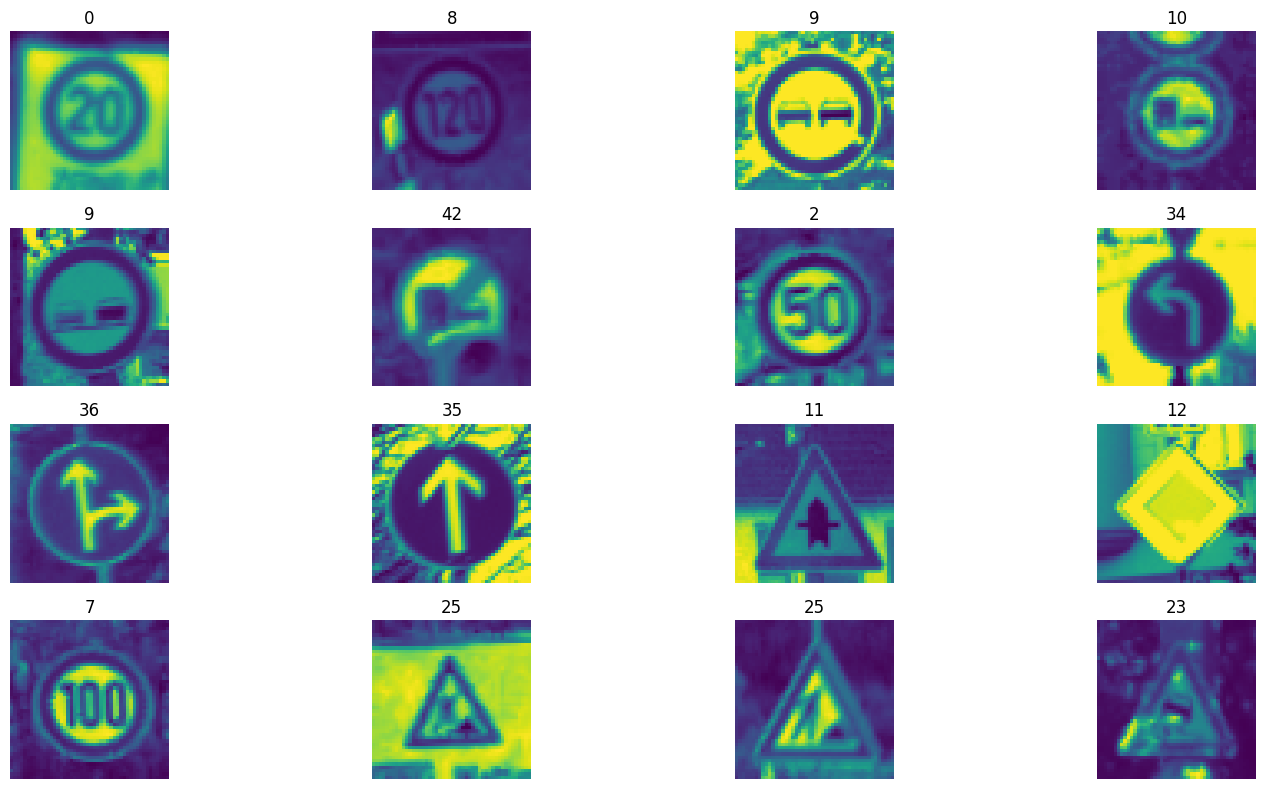

><


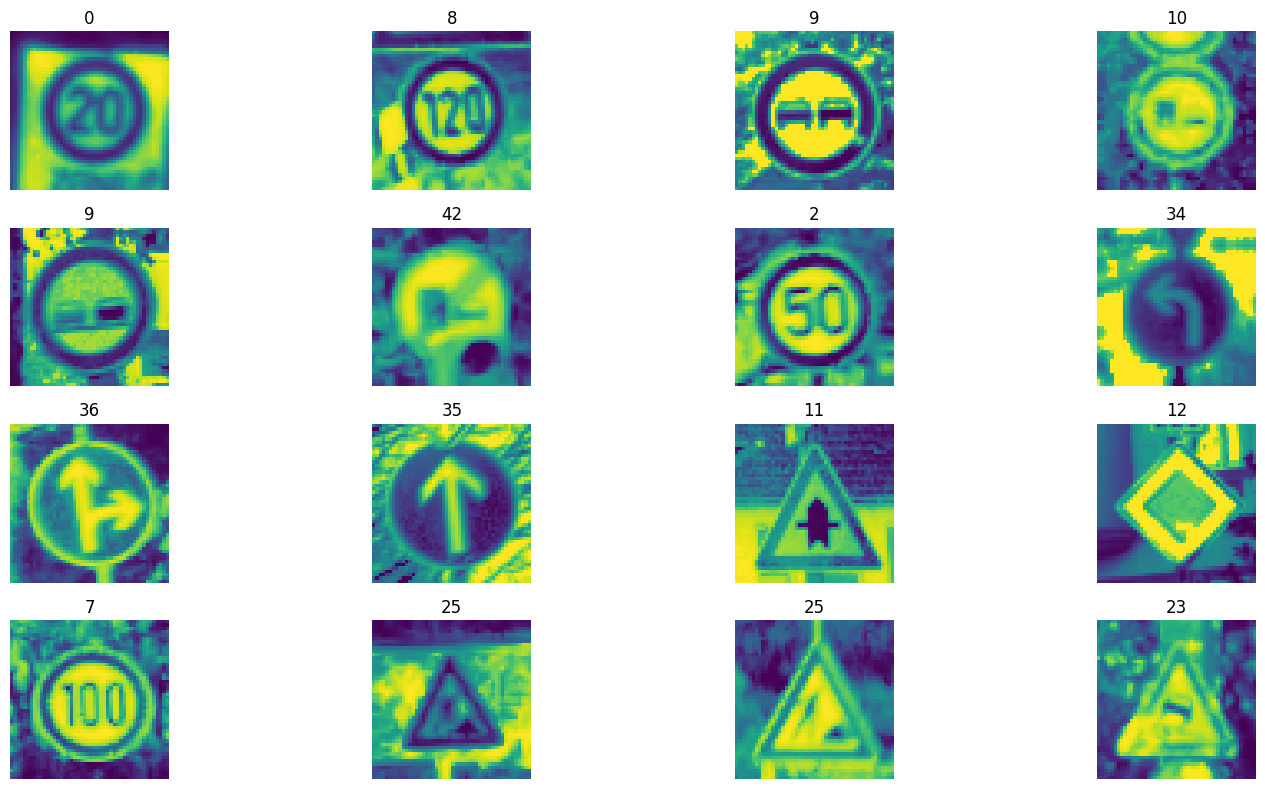

><


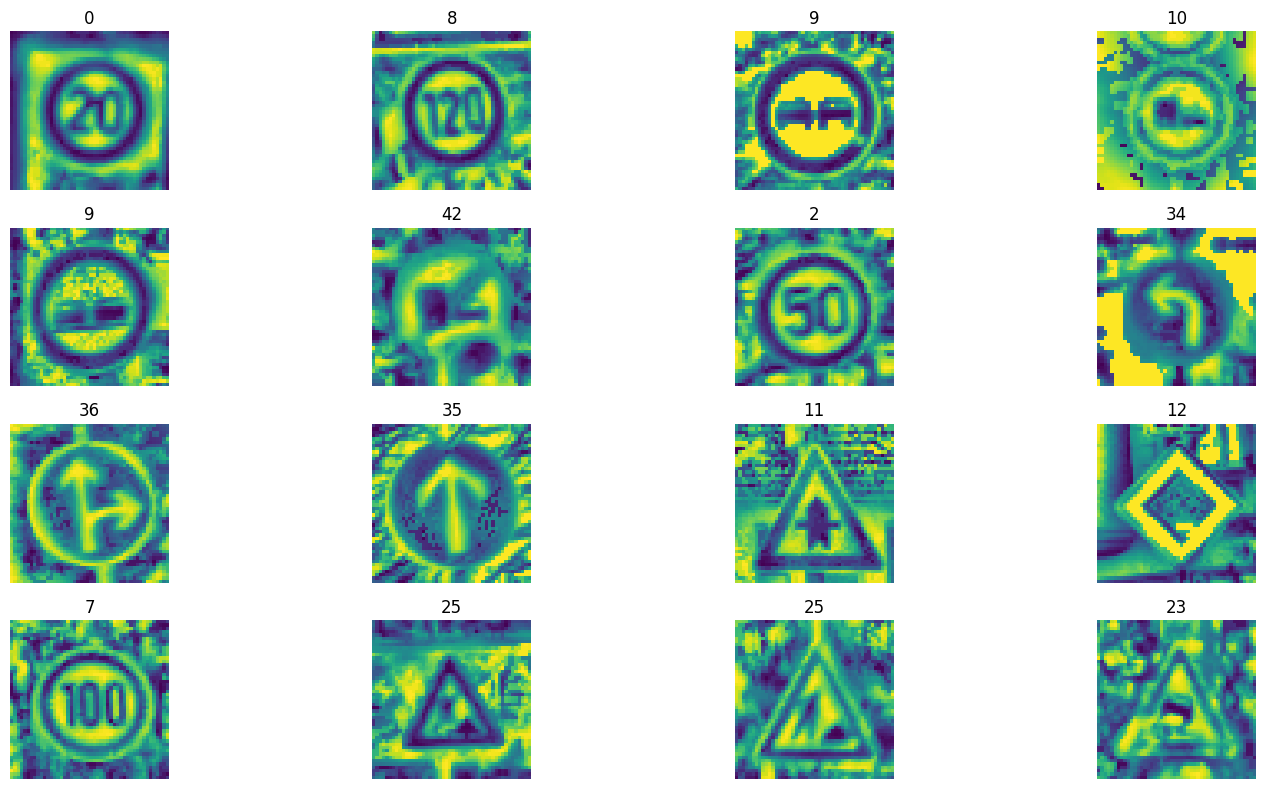

><


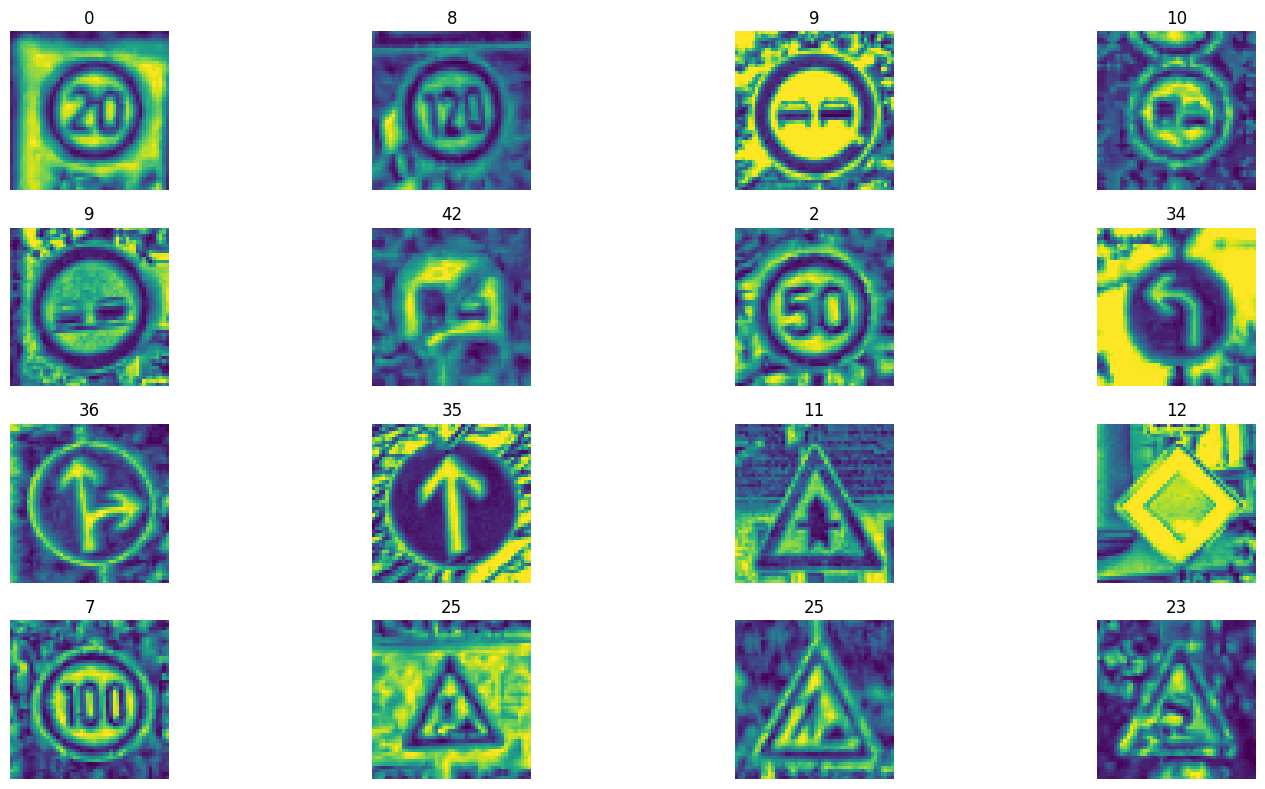

><


In [ ]:
i = random.randint(0, len(x_train) - 32)
x_samples = x_train[i : i + 32]
y_samples = y_train[i : i + 32]

# Dictionary
datasets  = {}

datasets['RGB']     = images_enhancement(x_samples, width=pixels, height=pixels, proc='RGB')
datasets['RGB-HE']  = images_enhancement(x_samples, width=pixels, height=pixels, proc='RGB-HE')
datasets['L']       = images_enhancement(x_samples, width=pixels, height=pixels, proc='L')
datasets['L-HE']    = images_enhancement(x_samples, width=pixels, height=pixels, proc='L-HE')
datasets['L-LHE']   = images_enhancement(x_samples, width=pixels, height=pixels, proc='L-LHE')
datasets['L-CLAHE'] = images_enhancement(x_samples, width=pixels, height=pixels, proc='L-CLAHE')

# Afficher les images pour chaque méthode de traitement
for key, images in datasets.items():
    show(images, y_samples)


# **A function to save a dataset (h5 file)**

In [ ]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, filename):

    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)

    # ---- done
    size=os.path.getsize(filename)/(2**20)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

# **Generate enhanced datasets**

In [ ]:
# ---- Size and processings
# create datasets with images of size 24x24 pixels and 48x48 pixels.
all_pixels= [pixels] # [24, 48, 96]

all_proc=['RGB', 'RGB-HE', 'L', 'L-LHE', 'L-LHE', 'L-CLAHE']

n_train = int(len(x_train) * ratio)
n_test  = int(len(x_test) * ratio)

print(f'ratio is : {ratio}')
print(f'x_train length is : {n_train}')
print(f'x_test  length is : {n_test}')
print(f'output dir is     : {output_dir}\n')

for px in all_pixels:
    for m in all_proc:
        # ---- A nice dataset name
        filename = f'{output_dir}/set-{px}x{px}-{m}.h5'
        # ---- Enhancement
        #      Note : x_train is a numpy array of python objects (images with <> sizes)
        #             but images_enhancement() return a real array of float64 numpy (images with same size)
        #             so, we can save it in nice h5 files
        #
        x_train_new = images_enhancement(x_train[:n_train], width=px, height=px, proc=m)
        x_test_new  = images_enhancement(x_test[:n_test],   width=px, height=px, proc=m)
        x_meta_new  = images_enhancement(x_meta,            width=px, height=px, proc='RGB')

        # ---- Save
        save_h5_dataset(x_train_new, y_train[:n_train], x_test_new, y_test[:n_test], x_meta_new, y_meta, filename)

x_train_new, x_test_new=0, 0
print('\nDone.')

ratio is : 0.1
x_train length is : 3920
x_test  length is : 1263
output dir is     : /content/drive/MyDrive/kaggle/work



Enhancing images: 100%|██████████| 43/43 [00:00<00:00, 543.89 image/s]


Dataset : /content/drive/MyDrive/kaggle/work/set-48x48-RGB.h5  shape : (3920, 48, 48, 3)      size :  137.8 Mo   (saved)


Enhancing images: 100%|██████████| 43/43 [00:00<00:00, 525.44 image/s]


Dataset : /content/drive/MyDrive/kaggle/work/set-48x48-RGB-HE.h5  shape : (3920, 48, 48, 3)      size :  137.8 Mo   (saved)


Enhancing images: 100%|██████████| 43/43 [00:00<00:00, 539.03 image/s]


Dataset : /content/drive/MyDrive/kaggle/work/set-48x48-L.h5  shape : (3920, 48, 48, 1)      size :   46.7 Mo   (saved)


Enhancing images: 100%|██████████| 43/43 [00:00<00:00, 532.78 image/s]


Dataset : /content/drive/MyDrive/kaggle/work/set-48x48-L-LHE.h5  shape : (3920, 48, 48, 1)      size :   46.7 Mo   (saved)


Enhancing images: 100%|██████████| 43/43 [00:00<00:00, 335.68 image/s]


Dataset : /content/drive/MyDrive/kaggle/work/set-48x48-L-LHE.h5  shape : (3920, 48, 48, 1)      size :   46.7 Mo   (saved)


Enhancing images: 100%|██████████| 43/43 [00:00<00:00, 521.84 image/s]


Dataset : /content/drive/MyDrive/kaggle/work/set-48x48-L-CLAHE.h5  shape : (3920, 48, 48, 1)      size :   46.7 Mo   (saved)

Done.


# **Reload data to be sure *.h5**

In [ ]:
def read_dataset(path_dir, dataset_name):
    '''
    Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:
        x_train,y_train, x_test,y_test data, x_meta,y_meta
    '''

    # ---- Read dataset
    #
    filename = f'{path_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]

    # ---- Shuffle train set
    x_train, y_train = shuffle(x_train, y_train)

    print("Rescaled shape >>> in:", x_train.shape, " out:", y_train.shape)
    return (x_train, y_train), (x_test, y_test), (x_meta, y_meta)

Rescaled shape >>> in: (3920, 48, 48, 3)  out: (3920,)


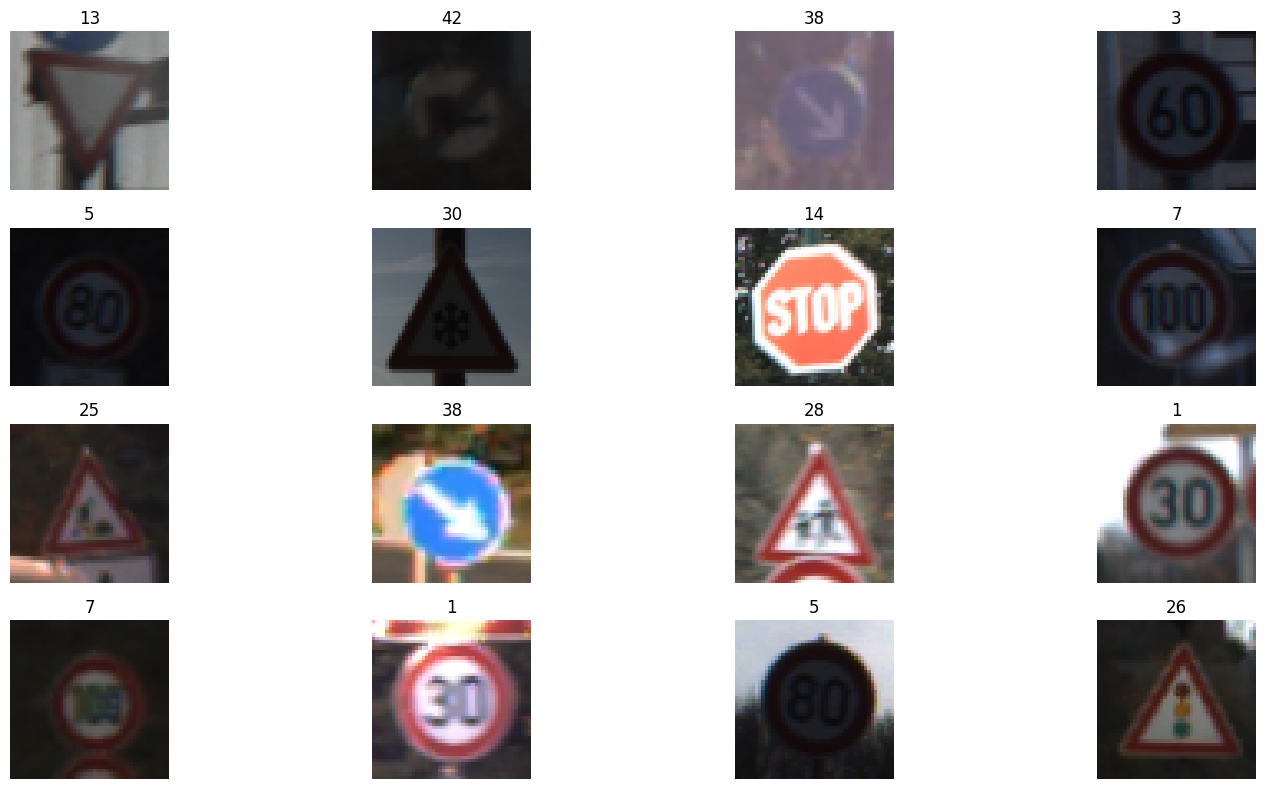

><


In [ ]:
dataset_name=f'set-{pixels}x{pixels}-RGB'
(x_tmp, y_tmp), (_,_), (_,_) = read_dataset(output_dir, dataset_name)
show(x_tmp, y_tmp)
x_tmp, y_tmp=0, 0

TensorFlow_logo.svg

In [ ]:
batch_size = 32
epochs = 10
optimizer=tf.keras.optimizers.Adam()
loss=tf.keras.losses.SparseCategoricalCrossentropy()
accurracy=tf.keras.metrics.SparseCategoricalAccuracy()
dataset_name = f'set-{pixels}x{pixels}-RGB'

In [ ]:
!mkdir -p '{output_dir_tmp}' && cp '{output_dir}/{dataset_name}.h5' '{output_dir_tmp}'

Rescaled shape >>> in: (3920, 48, 48, 3)  out: (3920,)
x_train shape :  (3920, 48, 48, 3)
y_train shape :  (3920,)
x_test  shape :  (1263, 48, 48, 3)
y_test  shape :  (1263,)


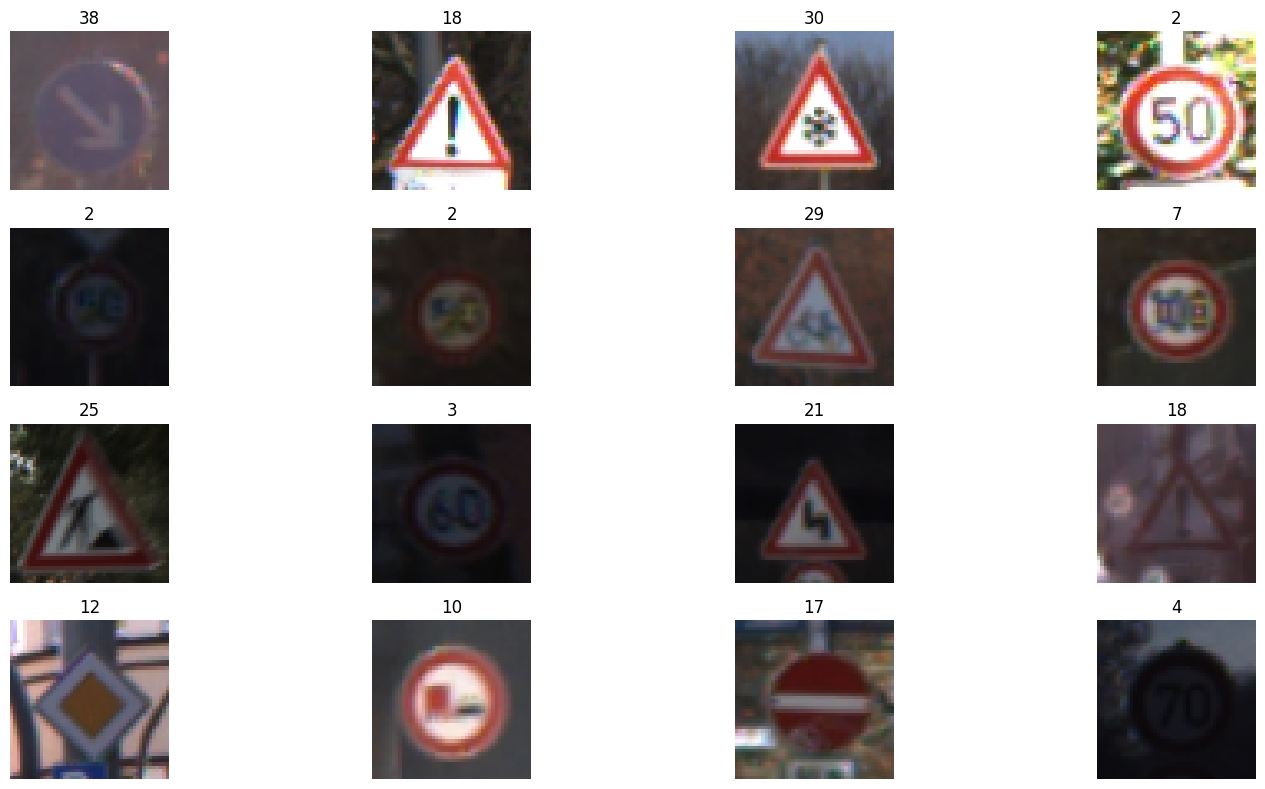

><


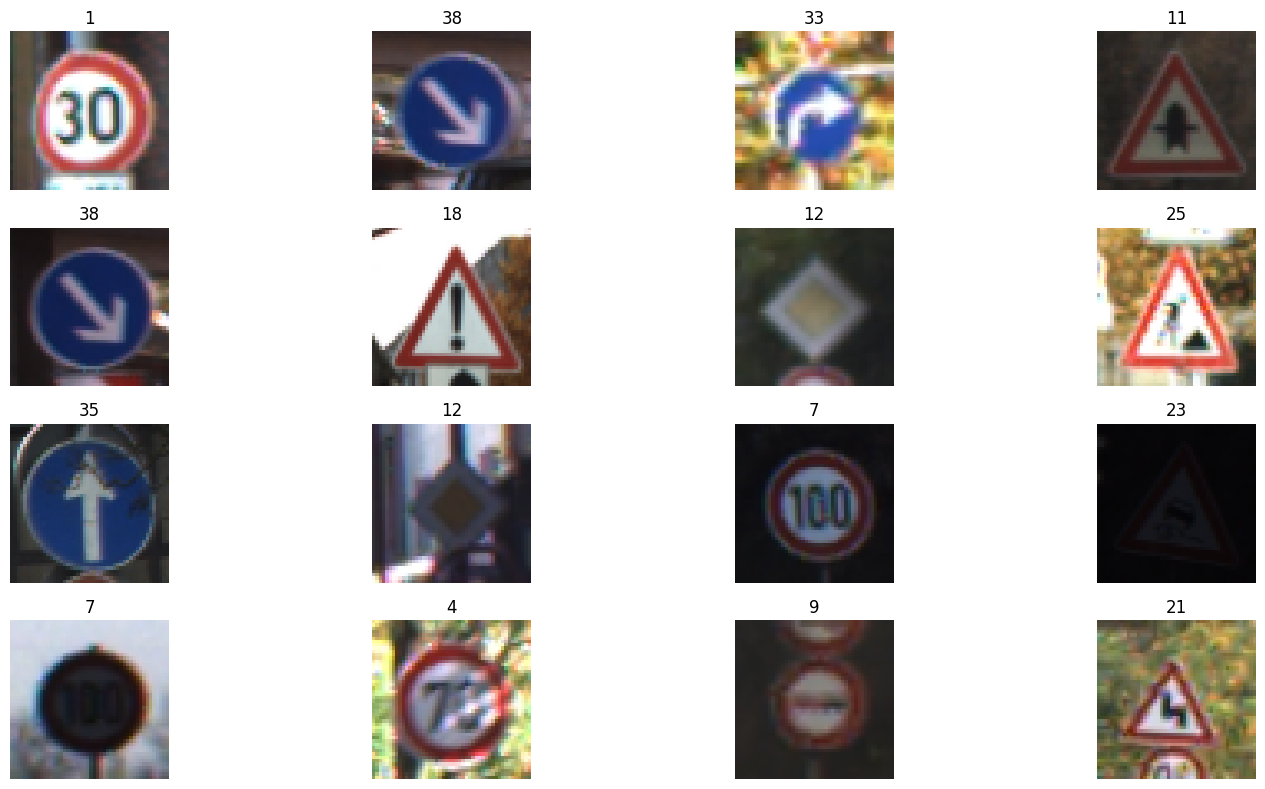

><


In [ ]:
(x_train, y_train), (x_test, y_test), (x_meta, y_meta) = read_dataset(output_dir_tmp, dataset_name)

print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test  shape : ", x_test.shape)
print("y_test  shape : ", y_test.shape)

show(x_train, y_train)
show(x_test, y_test)

# *Normalisation*

In [ ]:
# x_train /= 255.0
# x_test  /= 255.0
print("x_train shape : ", x_train.shape)
print("x_train_max   : ", x_train.max())
print("x_train_mean  : ", x_train.mean())
print("x_train_std   : ", x_train.std())
print("x_test_max    : ", x_test.max())
print("x_test_mean   : ", x_test.mean())
print("x_test_std    : ", x_test.std())

x_train shape :  (3920, 48, 48, 3)
x_train_max   :  1.0
x_train_mean  :  0.32641768
x_train_std   :  0.27135447
x_test_max    :  1.0
x_test_mean   :  0.32166198
x_test_std    :  0.26676083


In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, input_shape):
      super(CustomModel, self).__init__()

      self._input_shape  = input_shape
      self._00_CNN_Layer = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu)
      self._01_CNN_Layer = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu)
      self._00_Pooling   = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
      self._00_Dropout   = tf.keras.layers.Dropout(0.25)

      self._02_CNN_Layer = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu)
      self._03_CNN_Layer = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu)
      self._01_Pooling   = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
      self._01_Dropout   = tf.keras.layers.Dropout(0.25)

      self._04_CNN_Layer = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.nn.relu)
      self._05_CNN_Layer = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.nn.relu)
      self._02_Pooling   = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
      self._02_Dropout   = tf.keras.layers.Dropout(0.25)

      self._00_Flatten   =  tf.keras.layers.Flatten()
      self._00_Dense     =  tf.keras.layers.Dense(1024, activation=tf.nn.relu)
      self._01_Dense     =  tf.keras.layers.Dense(512, activation=tf.nn.relu)
      self._03_Dropout   =  tf.keras.layers.Dropout(0.25)
      self._02_Dense     =  tf.keras.layers.Dense(43, activation=tf.nn.softmax)

    def call_as_eagle(self, inputs, training=False):
      x = self._00_CNN_Layer(inputs)
      x = self._01_CNN_Layer(x)
      x = self._00_Pooling(x)
      x = self._00_Dropout(x, training=training)

      x = self._02_CNN_Layer(x)
      x = self._03_CNN_Layer(x)
      x = self._01_Pooling(x)
      x = self._01_Dropout(x, training=training)

      x = self._04_CNN_Layer(x)
      x = self._05_CNN_Layer(x)
      x = self._02_Pooling(x)
      x = self._02_Dropout(x, training=training)

      x = self._00_Flatten(x)
      x = self._00_Dense(x)
      x = self._01_Dense(x)
      x = self._03_Dropout(x, training=training)
      x = self._02_Dense(x)
      return x

    def model(self):
      x = tf.keras.Input(shape=self._input_shape)
      return tf.keras.Model(inputs=x, outputs=self.call_as_eagle(inputs=x))

    @tf.function
    def call(self, inputs, training=False):
      x = self._00_CNN_Layer(inputs)
      x = self._01_CNN_Layer(x)
      x = self._00_Pooling(x)
      x = self._00_Dropout(x, training=training)

      x = self._02_CNN_Layer(x)
      x = self._03_CNN_Layer(x)
      x = self._01_Pooling(x)
      x = self._01_Dropout(x, training=training)

      x = self._04_CNN_Layer(x)
      x = self._05_CNN_Layer(x)
      x = self._02_Pooling(x)
      x = self._02_Dropout(x, training=training)

      x = self._00_Flatten(x)
      x = self._00_Dense(x)
      x = self._01_Dense(x)
      x = self._03_Dropout(x, training=training)
      x = self._02_Dense(x)
      return x

    @tf.function
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [ ]:
model = CustomModel(input_shape=(pixels, pixels, 3))
model.model().summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 128)       73856     
                                                           

# *Config Tensorboard*

In [ ]:
log_dir = f"{output_dir_tmp}/logs/fit/" + datetime.now().strftime("%Y-%m-%d_%H:%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (x_test, y_test),
    callbacks=[tensorboard_callback]
)

Epoch 1/16
123/123 [==============================] - 115s 921ms/step - loss: 3.5041 - accuracy: 0.0571 - val_loss: 3.2227 - val_accuracy: 0.1251
Epoch 2/16
123/123 [==============================] - 112s 911ms/step - loss: 2.3142 - accuracy: 0.3196 - val_loss: 1.7893 - val_accuracy: 0.4283
Epoch 3/16
123/123 [==============================] - 113s 920ms/step - loss: 1.4860 - accuracy: 0.5202 - val_loss: 1.0839 - val_accuracy: 0.6437
Epoch 4/16
123/123 [==============================] - 113s 920ms/step - loss: 0.8897 - accuracy: 0.7115 - val_loss: 0.6009 - val_accuracy: 0.8124
Epoch 5/16
123/123 [==============================] - 111s 906ms/step - loss: 0.5464 - accuracy: 0.8281 - val_loss: 0.4665 - val_accuracy: 0.8575
Epoch 6/16
123/123 [==============================] - 116s 948ms/step - loss: 0.3515 - accuracy: 0.8824 - val_loss: 0.4813 - val_accuracy: 0.8638
Epoch 7/16
123/123 [==============================] - 126s 1s/step - loss: 0.2843 - accuracy: 0.9026 - val_loss: 0.2992 - va

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {output_dir_tmp}/logs/fit

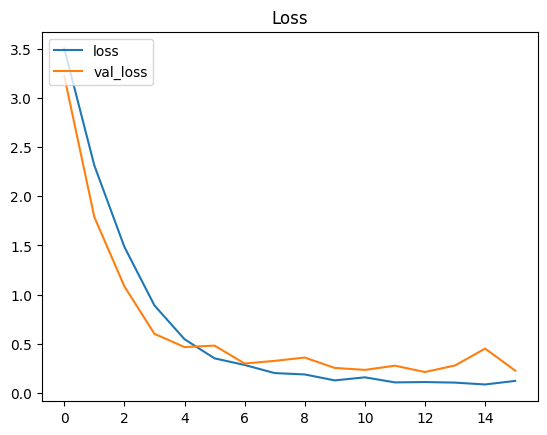

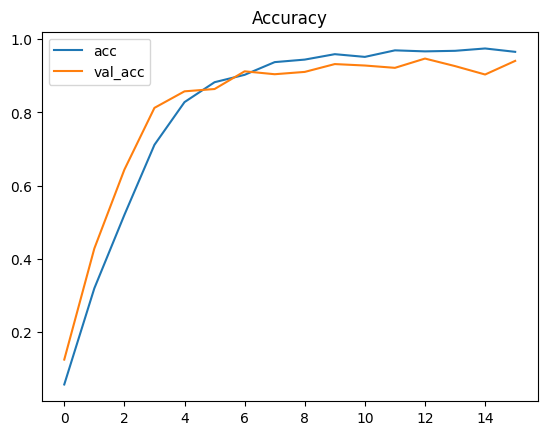

In [ ]:
loss = history.history["loss"]
acc = history.history["accuracy"]

val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

plt.title("Loss")
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc="upper left")
plt.show()

plt.title("Accuracy")
plt.plot(acc, label="acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc="upper left")
plt.show()

# **Show predictions**

40/40 [==============================] - 8s 188ms/step


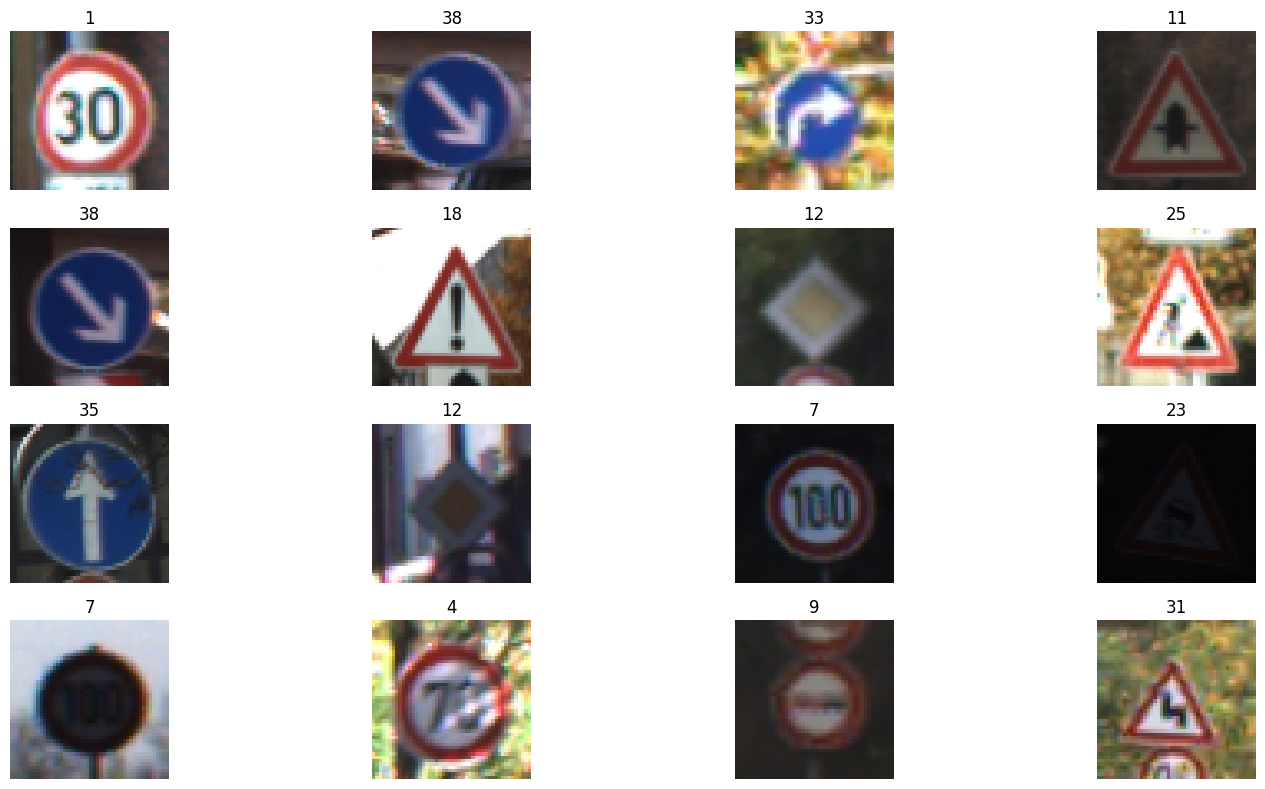

><


In [ ]:
pred = np.argmax(model.predict(x_test), axis=1)
show(x_test, pred)

# **Show errors**

nombre d'erreurs trouvées: 75


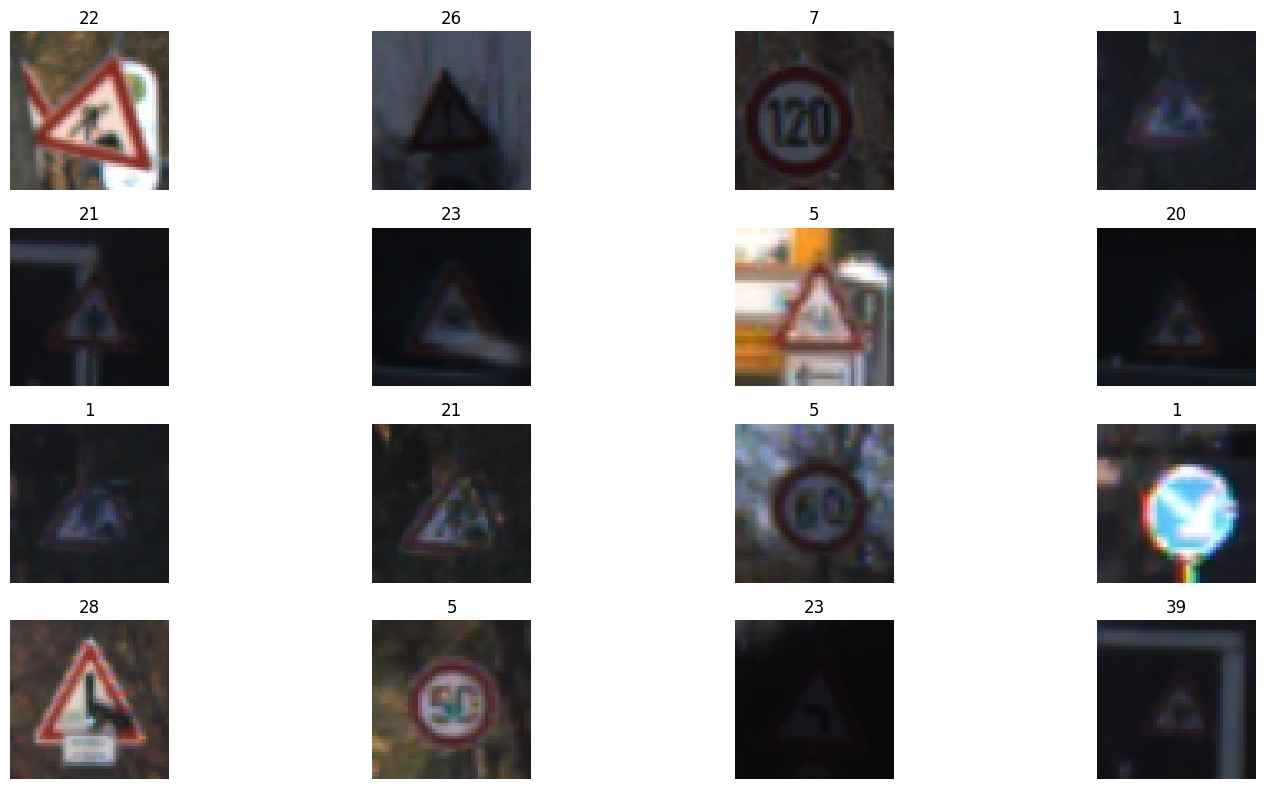

><


In [ ]:
# Générer la liste des indices d'erreurs
error_index = [i for i in range(len(x_test)) if pred[i] != y_test[i]]

# Obtenir les images en erreur
error_x_test = x_test[error_index]

# Obtenir les prédictions correspondantes aux images d'erreur
error_predictions = pred[error_index]

print("nombre d'erreurs trouvées:", len(error_index))
show(error_x_test, error_predictions, cmap="plasma")

# Save model

In [ ]:
datetime_format = datetime.now().strftime('%Y-%m-%d_%H-%M')
model.save(f'{output_dir}/model_{datetime_format}', save_format='tf')